# Setup

In [37]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

--2023-07-11 12:53:07--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.1’

conlleval.py.1      100%[===================>]   7.33K  --.-KB/s    in 0s      

2023-07-11 12:53:08 (35.0 MB/s) - ‘conlleval.py.1’ saved [7502/7502]



In [38]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate
import matplotlib.pyplot as plt


from tensorflow.keras import initializers

import random
import pandas as pd
import gc
from sklearn.model_selection import train_test_split

# Model

In [39]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [40]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [41]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32# maxlen = 200
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout1_1 = layers.Dropout(0.1)
        ###############
        self.conv1d = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation='relu')
        self.bn1    = tf.keras.layers.BatchNormalization()
        self.relu   = tf.keras.layers.ReLU()
        self.dropout3 = tf.keras.layers.Dropout(0.1)
        
        self.conv1d2 = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=3, padding='same', activation='relu')
        self.bn2    = tf.keras.layers.BatchNormalization()
        self.relu2   = tf.keras.layers.ReLU()
        self.dropout32 = tf.keras.layers.Dropout(0.1)
        
        self.lstm = tf.keras.layers.LSTM(units=ff_dim, return_sequences=True,
                                        kernel_initializer=initializers.glorot_uniform()
                                        )#True
        self.dropout4 = tf.keras.layers.Dropout(0.1)
        
        ##########
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff2 = layers.Dense(int(ff_dim/2), activation="relu")
        self.dropout2 = layers.Dropout(0.25)# 0.1
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        ########
        x = self.transformer_block2(x)
        x = self.dropout1_1(x, training=training)
        ###########
        x = self.conv1d(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout3(x, training=training)
        
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout32(x, training=training)
        
        #x = self.lstm(x)
        #x = self.dropout4(x, training=training)
        
        #########
        x = self.ff(x)
        x = self.ff2(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

# Dataset

In [42]:
dataset_path = "/kaggle/input/hishab-dataset-person-extractor/hishab_ds/hishab_ds/concatenated_bangla_ner_multiclass.csv"
df = pd.read_csv(dataset_path,index_col=False)
df.head(5)

,tokens,tags
0,"['\ufeffউন্নয়নের', 'বিস্ময়', 'বাংলাদেশ', 'বাংল...","['O', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O..."
1,"['অর্থনীতি', 'ও', 'আর্থসামাজিক', 'বেশির', 'ভাগ...","['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', '..."
2,"['নিম্ন', 'আয়ের', 'দেশগুলোকে', 'ছাড়িয়েছে', 'তো...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
3,"['আন্তর্জাতিক', 'মুদ্রা', 'তহবিল', '(', 'আইএমএ...","['B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O',..."
4,"['সবাইকে', 'অন্তর্ভুক্ত', 'করে', 'প্রবৃদ্ধি', ...","['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', '..."


* tokenizing the tokens and tags

In [43]:
tokens = df["tokens"].tolist()
tags   = df["tags"].tolist()
print(len(tokens),len(tags))

def tokenization(tokens,tags):
    ######## tags
    newTags = []
    newTokens = []
    for idx in range(len(tags)):
        demo1 = tags[idx]
        ## getting individual tags
        demo1 = demo1.replace("[", "" )# at first tabs necessary to add count
        demo1 = demo1.replace("]", "" )# at first tabs necessary to add count
        demo1 = demo1.replace("'", "" )# at first tabs necessary to add count
        demo1 = demo1.replace(" ", "" )# at first tabs necessary to add count
        demo1 = demo1.split(",")
        
        ###########
        demo2 = tokens[idx]
        ## getting individual tags
        demo2 = demo2.replace("[", "" )# at first tabs necessary to add count
        demo2 = demo2.replace("]", "" )# at first tabs necessary to add count
        demo2 = demo2.replace("'", "" )# at first tabs necessary to add count
        demo2 = demo2.replace(" ", "" )# at first tabs necessary to add count
        demo2 = demo2.split(",")
        
        if len(demo1) == len(demo2):
            newTags.append(demo1)
            newTokens.append(demo2)
    return newTokens,newTags

tokens,tags = tokenization(tokens,tags)
print(len(tokens),len(tags))

9926 9926
7963 7963


# Augmentation

* shuffling and random dropping

In [44]:
# shuffling
newtokens = []
newtags = []

newtokens2 = []
newtags2 = []

for i in range(len(tokens)):
    demoTags   = tags[i]
    demoTokens = tokens[i]
    
    idx = list(range(len(demoTokens)))
    random_element = random.choice(idx[:int(np.ceil(len(idx)/2))])# dropping
    random.shuffle(idx)# shuffling
    
    demo = []
    for j in idx:
        demo.append(demoTokens[j])
    newtokens.append(demo)
    newtokens2.append(demo[random_element:])
    
    demo = []
    for j in idx:
        demo.append(demoTags[j])
    newtags.append(demo)
    newtags2.append(demo[random_element:])
    #print(demoTokens,newtokens)
    #break
print(len(newtokens),len(newtags))
print(len(newtokens2),len(newtags2))

7963 7963
7963 7963


In [45]:
print(tokens[0])
print(tags[0])
print("\n")
print(newtokens[0])
print(newtags[0])
print("\n")
print(newtokens2[0])
print(newtags2[0])

['\\ufeffউন্নয়নের', 'বিস্ময়', 'বাংলাদেশ', 'বাংলাদেশের', 'অগ্রগতি', 'উদাহরণ', 'দেওয়ার', 'মতোই', '।']
['O', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O']


['অগ্রগতি', 'উদাহরণ', 'বাংলাদেশ', 'বিস্ময়', 'মতোই', '।', 'বাংলাদেশের', '\\ufeffউন্নয়নের', 'দেওয়ার']
['O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-LOC', 'O', 'O']


['উদাহরণ', 'বাংলাদেশ', 'বিস্ময়', 'মতোই', '।', 'বাংলাদেশের', '\\ufeffউন্নয়নের', 'দেওয়ার']
['O', 'B-LOC', 'O', 'O', 'O', 'B-LOC', 'O', 'O']


In [46]:
# concatenating
tokens = tokens + newtokens + newtokens2
tags = tags + newtags + newtags2
print(len(tokens),len(tags))

23889 23889


In [47]:
# converting to a dataframe
df = pd.DataFrame(columns=['tokens', 'tags'])
df.tokens = tokens
df.tags = tags
print(len(df))
df.head(5)

23889


,tokens,tags
0,"[\ufeffউন্নয়নের, বিস্ময়, বাংলাদেশ, বাংলাদেশের,...","[O, O, B-LOC, B-LOC, O, O, O, O, O]"
1,"[অর্থনীতি, ও, আর্থসামাজিক, বেশির, ভাগ, সূচকে, ...","[O, O, O, O, O, O, B-LOC, O, O, B-LOC, I-LOC, O]"
2,"[নিম্ন, আয়ের, দেশগুলোকে, ছাড়িয়েছে, তো, অনেক, আ...","[O, O, O, O, O, O, O, O]"
3,"[সবাইকে, অন্তর্ভুক্ত, করে, প্রবৃদ্ধি, অর্জনের,...","[O, O, O, O, O, O, B-LOC, O, O, O, O, O, B-LOC..."
4,"[তবে, অন্তর্ভুক্তিমূলক, প্রবৃদ্ধি, অর্জনে, বাং...","[O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O]"


* generating flag for sentences containing persons

In [48]:
tags   = df["tags"].tolist()

yIDX = []
for idx in range(len(tags)):
    demo = tags[idx]
    c = 0
    for j in range(len(demo)):
        #print(demo[j])
        if demo[j]=='B-PER' or demo[j]=='I-PER':
            c=1
    if c==1:
        yIDX.append(idx)

print(len(yIDX)) # extracted all sentences containing yes

nIDX = []
for idx in range(len(tags)):
    if idx not in yIDX:
        nIDX.append(idx)
print(len(nIDX))# extracted all sentences containing no
print(len(tags))

######## new column with class number
isYes = []
for i in range(len(tags)):
    if i in yIDX:
        isYes.append(1)
    else:
        isYes.append(0)
print(sum(isYes))

6139
17750
23889
6139


In [49]:
df['flag'] = isYes
df.head(5)

,tokens,tags,flag
0,"[\ufeffউন্নয়নের, বিস্ময়, বাংলাদেশ, বাংলাদেশের,...","[O, O, B-LOC, B-LOC, O, O, O, O, O]",0
1,"[অর্থনীতি, ও, আর্থসামাজিক, বেশির, ভাগ, সূচকে, ...","[O, O, O, O, O, O, B-LOC, O, O, B-LOC, I-LOC, O]",0
2,"[নিম্ন, আয়ের, দেশগুলোকে, ছাড়িয়েছে, তো, অনেক, আ...","[O, O, O, O, O, O, O, O]",0
3,"[সবাইকে, অন্তর্ভুক্ত, করে, প্রবৃদ্ধি, অর্জনের,...","[O, O, O, O, O, O, B-LOC, O, O, O, O, O, B-LOC...",0
4,"[তবে, অন্তর্ভুক্তিমূলক, প্রবৃদ্ধি, অর্জনে, বাং...","[O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O]",0


In [50]:
# saving to a csv file
#df.to_csv('concatened-augmented-ner-bangla-ds.csv',index=False)

# Splitting dataset

In [51]:
# train_test split depending on "flag" column
valid_split = 0.2
train_df, val_df = train_test_split(df, test_size=valid_split,random_state=42, stratify=df['flag'])
print(len(train_df),len(val_df))

19111 4778


In [52]:
def preprocessing_token_tags(df,reverse_mapping):
    tokens = df["tokens"].tolist()
    tags   = df["tags"].tolist()

    ######## tags
    newTags = []
    for idx in range(len(tags)):
        demo = tags[idx]

        for j in range(len(demo)):
            demo[j] = reverse_mapping[demo[j]]

        newTags.append(demo)

    return tokens,newTags

#train_tokens,train_tags = preprocessing_token_tags(train_df)
#val_tokens,val_tags = preprocessing_token_tags(val_df)
#print(len(train_tokens),len(train_tags))
#print(len(val_tokens),len(val_tags))

#print(train_tokens[5])
#print(train_tags[5])

In [53]:
# so that multiple occurance cannot happen
def reducing_mulOcc(text):
    processed_text = ""
    previous_char = ""

    for char in text:
        if char == "\t":
            if char != previous_char:
                processed_text += char
        else:
            processed_text += char

        previous_char = char
    return processed_text

### making ner lookup table

In [54]:
def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))

def reverse_make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["O"] + all_labels
    return dict(zip(all_labels,range(0, len(all_labels) + 1)))


mapping = make_tag_lookup_table()
print(mapping)
reverse_mapping = reverse_make_tag_lookup_table()
print(reverse_mapping)

{0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [55]:
list(mapping.values())

['[PAD]', 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [56]:
# reading as tab-separated file format as it would be easier for tf.data.Dataset object
def export_to_file(export_file_path, df,withoutYes):
    mismatch = []
    #withoutYes = 0#500
    newcount = 0
    with open(export_file_path, "w") as f:
        tokens,tags = preprocessing_token_tags(df,reverse_mapping)
        idx = 0
        for token, tag in zip(tokens, tags):
            if len(tokens) > 0 :
                #text =  "\t"+ "\t".join(token)+ "\t"+ "\t".join(map(str, tag))+ "\n"
                #processed_text = reducing_mulOcc(text)
                ##########
                newtoken = "\t".join(token) # taking new len
                newtoken = reducing_mulOcc(newtoken)
                newtoken = newtoken.split("\t")
                #processed_text = str(len(newtoken))+processed_text

                #########
                newtag = "\t".join(map(str, tag))
                newtag = reducing_mulOcc(newtag)
                newtag = newtag.split("\t")

                text =  str(len(newtoken))+"\t"+ "\t".join(newtoken)+ "\t"+ "\t".join(map(str, newtag))+ "\n"

                #if idx == 0:
                  #print(newtag)
                # only taking the matched ones
                if len(newtoken) != len(newtag):
                    mismatch.append(idx)
                else:
                  # only taking the sentences containing "yes" to reduce imbalanceness
                    
                
                    if "1" in newtag:
                        f.write(text)
                        newcount+=1
                    else:
                        if withoutYes>0:
                            f.write(text)
                            newcount+=1
                            withoutYes-=1

            idx+=1
    print("total number of sentneces %d"%newcount)
    return mismatch,idx-1

############# one time is good I guess
mistrain,totTrain = export_to_file("/kaggle/working/bangla_ner_train.txt", train_df,200)#500
misval,totVal     = export_to_file("/kaggle/working/bangla_ner_val.txt", val_df,100)#500

print(len(mistrain),totTrain)
print(len(misval),totVal)

#########################################
# this mismatched bithces are making all the error!
# for now getting rid of those bitches
# sentence number is quite low in this case

total number of sentneces 4850
total number of sentneces 1262
62 19110
16 4777


In [57]:
all_tokens_array = []
for i in range(len(tokens)):
    demo = tokens[i]
    for j in range(len(demo)):
        all_tokens_array.append(demo[j])

print(len(all_tokens_array))
###########
counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(
    vocabulary=vocabulary
)

338094
17501


In [58]:
train_data = tf.data.TextLineDataset("/kaggle/working/bangla_ner_train.txt")
val_data = tf.data.TextLineDataset("/kaggle/working/bangla_ner_val.txt")

In [59]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 8#4#32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

# initializing the model
#ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=32)#32
ner_model = NERModel(num_tags, vocab_size, embed_dim=64, num_heads=4, ff_dim=64)#32

### custom loss

In [60]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        # discarding the padding
        mask = tf.cast((y_true > 0), dtype=tf.float32)#tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        #######################
        ##### Making effect of "O" lower
        mask2 = tf.cast((y_true > 1), dtype=tf.float32)  # 0.5 loss for classes other than "O"
        #loss = loss *0.9* mask2 + (1 - mask2) *0.1*  loss
        
        
        ##################
        mask3 = tf.cast((y_true == 2), dtype=tf.float32)
        mask4 = tf.cast((y_true == 3), dtype=tf.float32)
        
        loss = loss *0.4* mask3+loss *0.4* mask4 +mask2 *0.04*  loss+ (1 - mask3) *0.08*  loss+(1 - mask4) *0.08*  loss
        
        # if possible add gradient seearch for this weight constant, it can be ratio I guess
        #######################
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

In [61]:
gc.collect()

2096

# Compile and fit model

In [62]:
EPOCHS = 15

weight_name = "binary_baseline_2.h5"
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=1e-9)
mdlcheckpoint_cb = tf.keras.callbacks.ModelCheckpoint(weight_name, monitor="val_loss", save_best_only=False,save_weights_only=True)#True
#metric = [loss]

ner_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4,weight_decay=0.1)#5e-3#0.001
                  #tf.keras.optimizers.Adam(learning_rate=5e-3,weight_decay=0.1)##"adam"
                  , loss=loss)#,metrics=metric#,metrics=["accuracy"]
history = ner_model.fit(train_dataset, epochs=EPOCHS,validation_data=val_dataset,callbacks=[lr_reduce,mdlcheckpoint_cb])#

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


607/607 [==============================] - 36s 46ms/step - loss: 0.2427 - val_loss: 0.1683 - lr: 5.0000e-04
Epoch 2/15
607/607 [==============================] - 27s 44ms/step - loss: 0.1341 - val_loss: 0.0993 - lr: 5.0000e-04
Epoch 3/15
607/607 [==============================] - 27s 45ms/step - loss: 0.0834 - val_loss: 0.0798 - lr: 5.0000e-04
Epoch 4/15
607/607 [==============================] - 28s 46ms/step - loss: 0.0624 - val_loss: 0.0764 - lr: 5.0000e-04
Epoch 5/15
607/607 [==============================] - 28s 47ms/step - loss: 0.0516 - val_loss: 0.0690 - lr: 5.0000e-04
Epoch 6/15
607/607 [==============================] - 28s 46ms/step - loss: 0.0429 - val_loss: 0.0658 - lr: 5.0000e-04
Epoch 7/15
607/607 [==============================] - 28s 46ms/step - loss: 0.0371 - val_loss: 0.0643 - lr: 5.0000e-04
Epoch 8/15
607/607 [==============================] - 27s 45ms/step - loss: 0.0332 - val_loss: 0.0608 - lr: 5.0000e-04
Epoch 9/15
607/607 [==============================] - 28s 4

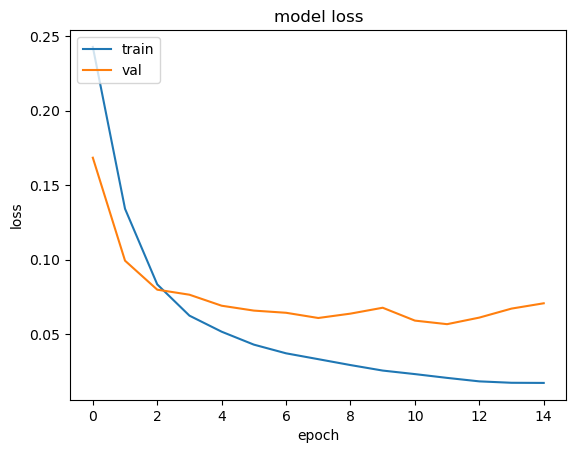

In [63]:
# plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Metrics calculation

In [64]:
ner_model.load_weights("/kaggle/working/"+weight_name)

In [65]:
# taking a line to test
i = 0
for element in val_data:
    #print(element)
    if i == 6:
        break
    i+=1
normal_string = element.numpy().decode()
print(normal_string)
length = normal_string[0]
print(length)
record = normal_string.split("\t")
print(record)
token = record[1:int(record[0])+1]
newtoken = "\t".join(token) # taking new len
newtoken = reducing_mulOcc(newtoken)
newtoken = newtoken.replace("\t", " " )
#newtoken = "গতকাল দলের ২৮তম প্রতিষ্ঠাবার্ষিকীর দুটি আলোচনা সভা আইনশৃঙ্খলা রক্ষাকারী বাহিনী করতে দেয়নি ।"
newtoken

19	:	সাংবাদিকের	প্রথম	যাচ্ছিলেন	যমুনা	কারখানা	মোটরসাইকেল	সরিষাবাড়ী	সার	শফিকুল	করতে	ইসলাম	প্রতিনিধি	পেশাগত	।	লিমিটেডে	দায়িত্ব	পালন	আলোর	0	0	3	0	3	4	0	5	4	1	0	2	0	0	0	4	0	0	4
1
['19', ':', 'সাংবাদিকের', 'প্রথম', 'যাচ্ছিলেন', 'যমুনা', 'কারখানা', 'মোটরসাইকেল', 'সরিষাবাড়ী', 'সার', 'শফিকুল', 'করতে', 'ইসলাম', 'প্রতিনিধি', 'পেশাগত', '।', 'লিমিটেডে', 'দায়িত্ব', 'পালন', 'আলোর', '0', '0', '3', '0', '3', '4', '0', '5', '4', '1', '0', '2', '0', '0', '0', '4', '0', '0', '4']


': সাংবাদিকের প্রথম যাচ্ছিলেন যমুনা কারখানা মোটরসাইকেল সরিষাবাড়ী সার শফিকুল করতে ইসলাম প্রতিনিধি পেশাগত । লিমিটেডে দায়িত্ব পালন আলোর'

In [66]:
def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    newtoken#"eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)

tf.Tensor(
[[  199 10389    29  4890  3142   865  1622  6552  6553  3039    48    83
    514  7656     2  5522   281   360   932]], shape=(1, 19), dtype=int64)
1/1 [==============================] - 1s 528ms/step
['O', 'O', 'B-ORG', 'O', 'B-ORG', 'I-ORG', 'O', 'B-LOC', 'I-ORG', 'B-PER', 'O', 'I-PER', 'O', 'O', 'O', 'I-ORG', 'O', 'O', 'I-ORG']


In [67]:
def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    ########
    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)

    ################################
    #############
    #using counter
    # Create counters for each list
    counter1 = Counter(predicted_tags)
    counter2 = Counter(real_tags)

    # Get the intersection of the counters
    intersection = counter1 & counter2

    # Calculate the total count of matching elements
    num_matching_elements = sum(intersection.values())

    print(num_matching_elements)
    print("predicted tokens")
    print(counter1)
    print("real tokens")
    print(counter2)

    ###########
    # Calculate accuracy
    total_tokens = len(real_tags)
    matching_tokens = sum(1 for pred, actual in zip(predicted_tags, real_tags) if pred == actual)
    accuracy = matching_tokens / total_tokens * 100

    print(f"Accuracy: {accuracy:.2f}%")
    print("\n\n")

    #############
    # Classes to compare
    classes = ['O']#list(mapping.values())

    # Compare and count common classes at each index
    count_common_classes = sum(1 for items in zip(predicted_tags, real_tags) if all(item in classes for item in items))

    print("Count of common classes at common indices for 'O' class:", count_common_classes,"out of %d classes"%(len(predicted_tags)))
    print("count percentage : %.4f"%(count_common_classes/len(predicted_tags)))

    classes = ['[PAD]', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
    # Compare and count common classes at each index
    count_common_classes = sum(1 for items in zip(predicted_tags, real_tags) if all(item in classes for item in items))

    print("Count of common classes at common indices without 'O' class:", count_common_classes,"out of %d classes"%(len(predicted_tags)-7736))
    print("count percentage : %.4f"%(count_common_classes/(len(predicted_tags)-7736)))

calculate_metrics(val_dataset)

1/1 [==============================] - 0s 28ms/step
processed 22834 tokens with 3221 phrases; found: 3196 phrases; correct: 2626.
accuracy:  81.74%; (non-O)
accuracy:  94.81%; precision:  82.17%; recall:  81.53%; FB1:  81.85
              LOC: precision:  87.05%; recall:  79.81%; FB1:  83.27  386
              ORG: precision:  71.51%; recall:  74.36%; FB1:  72.91  730
              PER: precision:  85.00%; recall:  84.27%; FB1:  84.63  2080
22676
predicted tokens
Counter({'O': 18798, 'B-PER': 1433, 'I-PER': 1234, 'I-ORG': 528, 'B-ORG': 454, 'B-LOC': 383, 'I-LOC': 4})
real tokens
Counter({'O': 18677, 'B-PER': 1418, 'I-PER': 1305, 'I-ORG': 562, 'B-ORG': 432, 'B-LOC': 395, 'I-LOC': 45})
Accuracy: 94.81%



Count of common classes at common indices for 'O' class: 18252 out of 22834 classes
count percentage : 0.7993
Count of common classes at common indices without 'O' class: 3611 out of 15098 classes
count percentage : 0.2392


# Extracting persons' name

In [68]:
def get_person(given_string):
    tokens = given_string.split(" ")
    print(tokens)
    # Sample inference using the trained model
    sample_input = tokenize_and_convert_to_ids(given_string)
    sample_input = tf.reshape(sample_input, shape=[1, -1])

    output = ner_model.predict(sample_input)
    prediction = np.argmax(output, axis=-1)[0]
    prediction = [mapping[i] for i in prediction]

    print(prediction)

    #### extraction part
    toExtract = []
    for j in range(len(prediction)):
        if prediction[j] == 'I-PER' or prediction[j] == 'B-PER':
            toExtract.append(tokens[j])
    print(toExtract)

In [69]:
given_string = "প্রতিবেদক ছিলেন সাপ্তাহিকের রাজশাহীর বিভাগীয় প্রতিনিধি সায়েম সাবু ।"
get_person(given_string)

['প্রতিবেদক', 'ছিলেন', 'সাপ্তাহিকের', 'রাজশাহীর', 'বিভাগীয়', 'প্রতিনিধি', 'সায়েম', 'সাবু', '।']
1/1 [==============================] - 0s 27ms/step
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'B-PER', 'I-PER', 'O']
['সায়েম', 'সাবু']


In [70]:
given_string = "এতে রয়েছে কত্থক ‘গীতমালিকা’ শীর্ষক নৃত্য পরিবেশনা।"
get_person(given_string)

['এতে', 'রয়েছে', 'কত্থক', '‘গীতমালিকা’', 'শীর্ষক', 'নৃত্য', 'পরিবেশনা।']
1/1 [==============================] - 0s 27ms/step
['O', 'O', 'O', 'O', 'O', 'O', 'O']
[]


In [71]:
given_string = "নিরাপত্তা কর্মকর্তা জান মোহাম্মদ আদালতকে মোশাররফের ‘অসুস্থতা’ সম্পর্কে অবহিত করেন ।"
get_person(given_string)

['নিরাপত্তা', 'কর্মকর্তা', 'জান', 'মোহাম্মদ', 'আদালতকে', 'মোশাররফের', '‘অসুস্থতা’', 'সম্পর্কে', 'অবহিত', 'করেন', '।']
1/1 [==============================] - 0s 27ms/step
['O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O']
['জান', 'মোহাম্মদ', 'মোশাররফের']


In [72]:
given_string = "প্রেমের ময়দানে ক্যারোলিন ওজনিয়াকি আর ররি ম্যাকইলরয়ের লক্ষণীয় উন্নতিই হয়েছে ।"
get_person(given_string)

['প্রেমের', 'ময়দানে', 'ক্যারোলিন', 'ওজনিয়াকি', 'আর', 'ররি', 'ম্যাকইলরয়ের', 'লক্ষণীয়', 'উন্নতিই', 'হয়েছে', '।']
1/1 [==============================] - 0s 26ms/step
['O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O']
['ক্যারোলিন', 'ওজনিয়াকি', 'ররি', 'ম্যাকইলরয়ের']


In [73]:
given_string = "আমার সোনার বাংলা আমি তোমায় ভালবাসি"
get_person(given_string)

['আমার', 'সোনার', 'বাংলা', 'আমি', 'তোমায়', 'ভালবাসি']
1/1 [==============================] - 0s 29ms/step
['O', 'O', 'O', 'O', 'O', 'O']
[]


# Conclusion